# Transformation of csv from oscilloscope to HDF5 file

In [1]:
import matplotlib.pyplot as plt
import glob
import os
import time
import pandas as pd 
%pylab inline --no-import-all

file = "/storage/experiments/2021/0807_bourka_sobeslav/slavia/csv/RigolDS3.csv"
file = "RigolDS0.csv"



Populating the interactive namespace from numpy and matplotlib


In [28]:
df = pd.read_table(file, sep=',', header=0)

In [29]:
df['time']=df.index*8e-9-0.2

In [30]:
df.set_index('time', inplace=True)

In [31]:
cols_to_keep = ['CH1(V)', 'CH2(V)']
df.loc[:, cols_to_keep].to_hdf(file+'.hdf','df', mode='w')

In [2]:
df=pd.read_hdf(file+'.hdf')
df['CH2(V)']

time
-0.200000   -0.003634
-0.200000   -0.001817
-0.200000   -0.001817
-0.200000   -0.003634
-0.200000   -0.001817
               ...   
 0.602816   -0.001817
 0.602816   -0.001817
 0.602816   -0.001817
 0.602816   -0.001817
 0.602816   -0.001817
Name: CH2(V), Length: 100352000, dtype: float64

Text(0, 0.5, 'Voltage [V]')

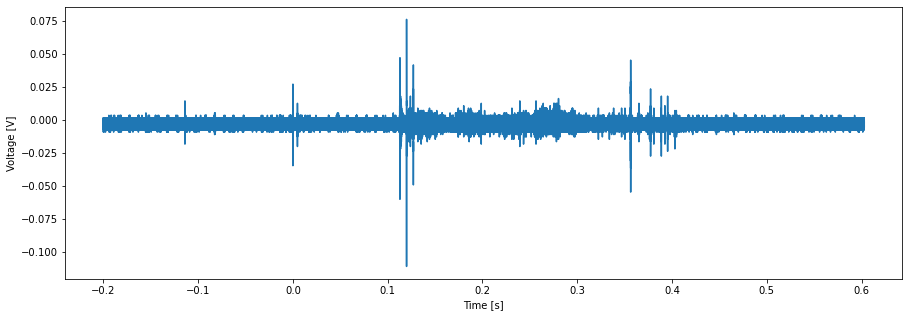

In [3]:
plt.figure(figsize=(15,5))
plt.plot(df['CH2(V)'])
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.grid()

In [34]:
df

,CH1(V),CH2(V)
time,,
-0.200000,0.000000,-0.003634
-0.200000,0.016993,-0.001817
-0.200000,-0.008497,-0.001817
-0.200000,0.000000,-0.003634
-0.200000,0.008497,-0.001817
...,...,...
0.602816,0.008497,-0.001817
0.602816,0.016993,-0.001817
0.602816,0.000000,-0.001817


KeyboardInterrupt: 

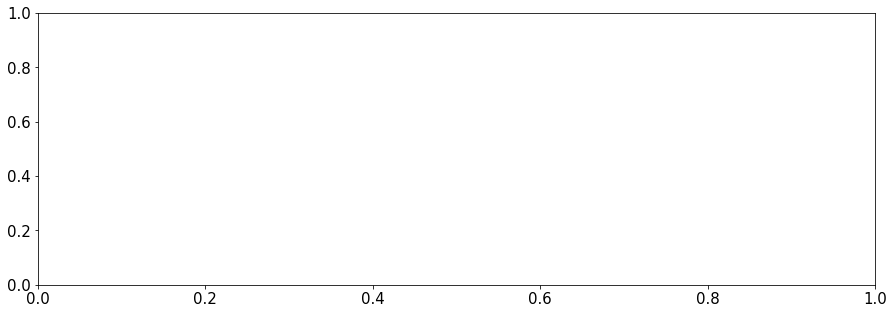

In [17]:
plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

#plt.plot(df['CH1(V)'], label='CH1')
plt.plot(df.loc[:100,'CH2(V)'], label='CH2')
plt.ylim(-0.2,0.2)
#plt.legend()
plt.grid()